In [80]:
###hdf file loading package
from pyhdf.SD  import SD, SDC
from pyhdf.V import *
from pyhdf.HDF import *
### for some calculation and presentation
import pprint
import numpy as np
import math as ma
import pandas as pd
### for data output 
#import pickle
### self-defined function
from satellite_read_tool import HDFvars, rFilter
# HDFvars: load variable name from Scientific Dataset
# rFilter: select region we want (base on lat and lon range)
###
###drawing package  Use what you familiar
import os
os.environ['PROJ_LIB'] = 'D:\\program\\anaconda3\\Library\\share\\'
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap

In [81]:
## 2009/08/7 Typhoon Morakot profile
# 2B-GEOPROF & 2B-FLXHR-LIDAR  -- R05
geo_file = 'data/2009219043145_17429_CS_2B-GEOPROF_GRANULE_P1_R05_E02_F00.hdf'
f_lidar_file = 'data/2009219043145_17429_CS_2B-FLXHR-LIDAR_GRANULE_P2_R05_E02_F00.hdf'

In [82]:
## get each hdf file's geolocation info
## CloudSat's geolocation info should be in the vdata
reading_vdata = HDF(geo_file, HC.READ).vstart()
vdata =reading_vdata.vdatainfo()
pprint.pprint(vdata[:]) # print vdata info

[('Profile_time', '', 7, 37080, 1, 0, 4, 1962, 0),
 ('UTC_start', '', 8, 1, 1, 0, 4, 1962, 0),
 ('TAI_start', '', 9, 1, 1, 0, 8, 1962, 0),
 ('Latitude', '', 10, 37080, 1, 0, 4, 1962, 0),
 ('Longitude', '', 11, 37080, 1, 0, 4, 1962, 0),
 ('Range_to_intercept', '', 14, 37080, 1, 0, 4, 1962, 0),
 ('DEM_elevation', '', 15, 37080, 1, 0, 2, 1962, 0),
 ('Vertical_binsize', '', 16, 1, 1, 0, 4, 1962, 0),
 ('Pitch_offset', '', 17, 1, 1, 0, 4, 1962, 0),
 ('Roll_offset', '', 18, 1, 1, 0, 4, 1962, 0),
 ('Data_quality', '', 19, 37080, 1, 0, 1, 1962, 0),
 ('Data_status', '', 20, 37080, 1, 0, 2, 1962, 0),
 ('Data_targetID', '', 21, 37080, 1, 0, 1, 1962, 0),
 ('RayStatus_validity', '', 22, 37080, 1, 0, 1, 1962, 0),
 ('SurfaceHeightBin', '', 23, 37080, 1, 0, 1, 1962, 0),
 ('SurfaceHeightBin_fraction', '', 24, 37080, 1, 0, 4, 1962, 0),
 ('Sigma-Zero', '', 31, 37080, 1, 0, 2, 1962, 0),
 ('MODIS_cloud_flag', '', 32, 37080, 1, 0, 1, 1962, 0),
 ('MODIS_Cloud_Fraction', '', 33, 37080, 1, 0, 1, 1962, 0),
 ('MO

In [83]:
### load vdata variables (geolocation info)
## longitude, latitude 
## data quality: value<=0 means data okay, SurfaceHeightBin: surface height at which bin: [1~125] 
members = [ 10, 11, 19, 23]  ## vdata id num
nrecs = []
names = []
for ref in members:
    vd = reading_vdata.attach(ref)
    nrecs.append(vd.inquire()[0])  ## number of records of the Vdata
    names.append(vd.inquire()[-1]) ## name of the Vdata
    vd.detach()
print(names) ## print variable name
#print(nrecs) ## variable array length

## load geolocation data
# longitude
idx = names.index('Longitude',)
var = reading_vdata.attach(members[idx])
longitude = var.read(nrecs[idx])
# latitude
idx = names.index('Latitude',)
var = reading_vdata.attach(members[idx])
latitude = var.read(nrecs[idx])
# data quality
idx = names.index('Data_quality',)
var = reading_vdata.attach(members[idx])
data_quality = var.read(nrecs[idx])
# surface height position 
idx = names.index('SurfaceHeightBin')
var = reading_vdata.attach(members[idx])
Height_bin = var.read(nrecs[idx])

['Latitude', 'Longitude', 'Data_quality', 'SurfaceHeightBin']


In [49]:
## longitude demo
# CloudSat lon range: -180~180
lon_demo = pd.DataFrame(longitude[:], columns= ['Longitude'])
print(lon_demo.shape)
print(lon_demo.head())
## latitude demo
# CloudSat lat range: -90~90
lat_demo = pd.DataFrame(latitude[:], columns= ['Latitude'])
print(lat_demo.shape)
print(lat_demo.head())

(37080, 1)
   Longitude
0 -40.985596
1 -40.987648
2 -40.989697
3 -40.991745
4 -40.993797
(37080, 1)
   Latitude
0 -0.008769
1 -0.018439
2 -0.028110
3 -0.037780
4 -0.047450


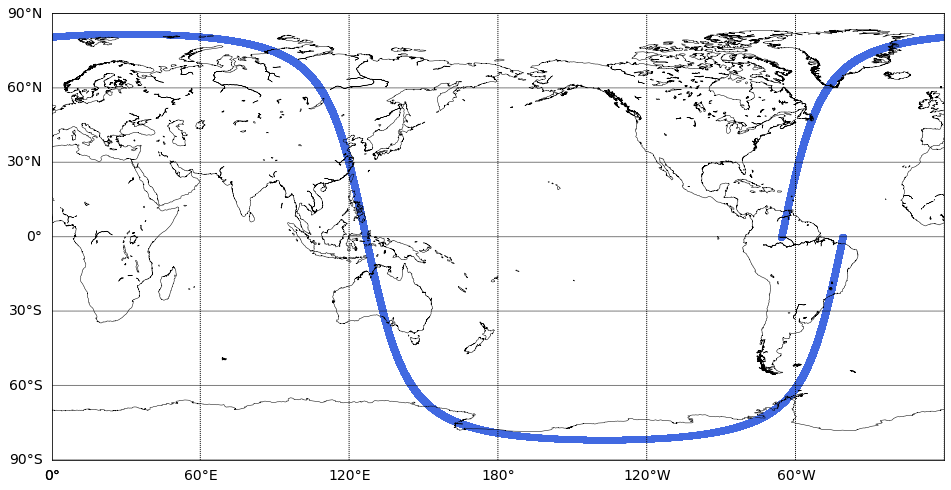

In [64]:
## change the lon range from -180~180 to 0~360 ## for drawing
lon = np.array(longitude)
modify_lon = np.where(lon  >= 0, lon , lon +360)
## one CloudSat Swath demo
## only day-time obervation after 2011
fig = plt.figure(figsize=(16,12)) 
m = Basemap(llcrnrlon=0, urcrnrlon=360., llcrnrlat=-90., urcrnrlat=90.,resolution='l')
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0], fontsize=14)
m.drawmeridians(np.arange(-180., 181., 60.), labels=[0, 0, 0, 1], fontsize=14)
m.scatter(modify_lon[:], latitude[:] , c='royalblue')

In [65]:
## select our study region
## lon: 0~360; lat: 90~-90 (same as era-interim or era5)
real_lon_cen = 120
real_lat_cen = 18
lon_range = 10
lat_range = 8
## latitude & longitude range for regional filter
lon_cloudsat = [real_lon_cen-lon_range,real_lon_cen+lon_range]
lat_cloudsat = [real_lat_cen-lat_range,real_lat_cen+lat_range]

In [52]:
## filtered the CloudSat data
region_mask = rFilter(longitude,latitude,lon_cloudsat,lat_cloudsat)

In [53]:
# list to numpy array
pre_lon = np.array(longitude)
pre_lat = np.array(latitude)
qua = np.array(data_quality)
height_bin = np.array(Height_bin)

In [67]:
### GEOPROF  SD data load
var_name = HDFvars(geo_file) # 2D variable name e.g.var[track_cloumns,125]
print(var_name)
hdfFile = SD(geo_file,SDC.READ)
## load data
# cloud mask
Cloud_mask = hdfFile.select('CPR_Cloud_mask')
cloud_mask = Cloud_mask[:,:]
# reflectivity
Reflectivity = hdfFile.select('Radar_Reflectivity')
reflectivity = Reflectivity[:,:]/100 # divided by factor
# bin hieght
Height = hdfFile.select('Height')
height = Height[:,:]

['CPR_Cloud_mask', 'Gaseous_Attenuation', 'Height', 'Radar_Reflectivity']


In [77]:
print(Cloud_mask)
aa = Reflectivity[19603:21260,:]
print(aa.shape)

(1657, 125)


In [55]:
### filter from all swath data to our study region
### all data should be filtered by regional mask & quality mask
## quality mask 
qua_mask = qua[region_mask[:,0]>0]
# longitude 
e_lon = pre_lon[region_mask[:,0]>0,0]
eq_lon = e_lon[qua_mask[:,0]<0.5]
# latitude 
e_lat = pre_lat[region_mask[:,0]>0,0]
eq_lat = e_lat[qua_mask[:,0]<0.5]
# surface height 
e_height_bin = height_bin[region_mask[:,0]>0]
eq_height_bin = e_height_bin[qua_mask[:,0]<0.5]
eq_height_bin = np.where(eq_height_bin >= 0, eq_height_bin, 125) # fill the missing value with 125
# cloud mask
e_cloud_mask = cloud_mask[region_mask[:,0]>0,:]
eq_cloud_mask = e_cloud_mask[qua_mask[:,0]<0.5,:]
# reflectivity
e_ref = reflectivity[region_mask[:,0]>0,:]
eq_ref = e_ref[qua_mask[:,0]<0.5,:]
# height info
e_height = height[region_mask[:,0]>0,:]
eq_height = e_height[qua_mask[:,0]<0.5,:]
## EC pressure
#e_pressure = pressure[region_mask[:,0]>0,:]
#eq_pressure = e_pressure[qua_mask[:,0]<0.5,:]

In [56]:
### regional data array length
region_array_size = eq_cloud_mask.shape
print(region_array_size[0])

1657


In [57]:
pre_lon = np.where(pre_lon  >= 0, pre_lon , pre_lon +360)
eq_lon = np.where(eq_lon  >= 0, eq_lon , eq_lon+360)

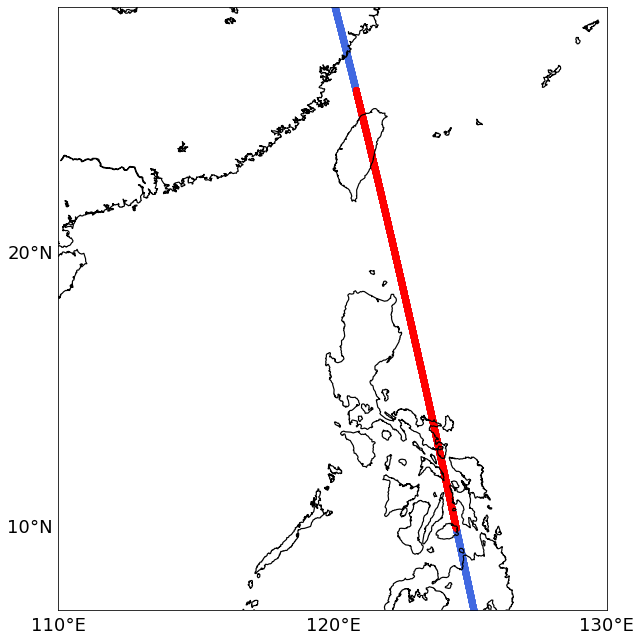

In [59]:
### plot regional swath demo
fig = plt.figure(figsize=(9,9)) 
# lat lon setting
m = Basemap(llcrnrlon=lon_cloudsat[0], urcrnrlon=lon_cloudsat[1], llcrnrlat=lat_cloudsat[0]-3, urcrnrlat=lat_cloudsat[1]+3,resolution='i')
m.drawcoastlines(linewidth=1.2,color='k')
m.drawparallels(np.arange(-90., 91., 10.), labels=[1, 0, 0, 0], linewidth=0, color='k', fontsize=18)
m.drawmeridians(np.arange(0., 360., 10.), labels=[0, 0, 0, 1], linewidth=0, color='k', fontsize=18)
#m.pcolormesh(local_lon,local_lat,rgb[:,:,0],color=color_t)
# draw swath (blue: total swath; red: filtered swath)
mo_lon = np.where(pre_lon  >= 0, pre_lon , pre_lon +360)
m.scatter(pre_lon[:], pre_lat[:] , c='royalblue')
mo_eq_lon = np.where(eq_lon  >= 0, eq_lon , eq_lon+360)
m.scatter(eq_lon[:], eq_lat[:] , c='r')
plt.tight_layout()

In [100]:
print(eq_height[5,:])

[25015 24775 24536 24296 24056 23816 23576 23336 23097 22857 22617 22377
 22137 21897 21658 21418 21178 20938 20698 20458 20219 19979 19739 19499
 19259 19020 18780 18540 18300 18060 17820 17581 17341 17101 16861 16621
 16381 16142 15902 15662 15422 15182 14942 14703 14463 14223 13983 13743
 13503 13264 13024 12784 12544 12304 12064 11825 11585 11345 11105 10865
 10625 10386 10146  9906  9666  9426  9187  8947  8707  8467  8227  7987
  7748  7508  7268  7028  6788  6548  6309  6069  5829  5589  5349  5109
  4870  4630  4390  4150  3910  3670  3431  3191  2951  2711  2471  2231
  1992  1752  1512  1272  1032   793   553   313    73  -167  -407  -646
  -886 -1126 -1366 -1606 -1846 -2085 -2325 -2565 -2805 -3045 -3285 -3524
 -3764 -4004 -4244 -4484 -4724]


In [101]:
## Surface height bins
height_bin_demo =  pd.DataFrame(Height_bin[:], columns= ['Sruface height bin'])
print(height_bin_demo.shape)
print(height_bin_demo.head())
print('Highest bin: ',np.min(Height_bin))
print('lowest bin: ',np.max(Height_bin))

(37080, 1)
   Sruface height bin
0                 105
1                 105
2                 105
3                 105
4                 105
Highest bin:  88
lowest bin:  106


In [102]:
print('Surface height bin: ',eq_height_bin[5])
print(eq_height[5,104])
print(eq_height[5,105])

Surface height bin:  [105]
73
-167


In [104]:
print(eq_height[0:10,80])
print(np.max(eq_height[:,80]))
print(np.min(eq_height[:,80]))
for i in range(0,15):
    #print(eq_height[0+i*100:100+i*100,80])
    a = np.max(eq_height[0+i*100:100+i*100,80])
    b = np.min(eq_height[0+i*100:100+i*100,80])
    print(a-b)

[5831 5831 5830 5830 5829 5829 5828 5828 5828 5827]
5875
5636
33
20
9
4
10
26
25
34
239
53
61
72
239
81
94


In [28]:
##R05
## transpose the array then overturn the columns, just for drawing
# cloud mask
t_cloud = eq_cloud_mask[:,:].T
r_cloud = t_cloud[::-1]
# reflectivity
t_ref = eq_ref[:,:].T
r_ref = t_ref[::-1]
# reference height for y axis 
t_hei = eq_height[:,:].T
#r_height = t_hei[::-1]
r_height = t_hei[::-1]
ref_height = np.mean(r_height,axis=1)
# unit: meter --> km
ref_height = np.around(ref_height/1000,decimals=1)
# latitude for x axis
region_lat = np.around(eq_lat,decimals=1)

In [99]:
print(eq_height.shape)
print(r_height.shape)
print(eq_height[5,:])
print(r_height[:,5])

(1657, 125)
(125, 1657)
[25015 24775 24536 24296 24056 23816 23576 23336 23097 22857 22617 22377
 22137 21897 21658 21418 21178 20938 20698 20458 20219 19979 19739 19499
 19259 19020 18780 18540 18300 18060 17820 17581 17341 17101 16861 16621
 16381 16142 15902 15662 15422 15182 14942 14703 14463 14223 13983 13743
 13503 13264 13024 12784 12544 12304 12064 11825 11585 11345 11105 10865
 10625 10386 10146  9906  9666  9426  9187  8947  8707  8467  8227  7987
  7748  7508  7268  7028  6788  6548  6309  6069  5829  5589  5349  5109
  4870  4630  4390  4150  3910  3670  3431  3191  2951  2711  2471  2231
  1992  1752  1512  1272  1032   793   553   313    73  -167  -407  -646
  -886 -1126 -1366 -1606 -1846 -2085 -2325 -2565 -2805 -3045 -3285 -3524
 -3764 -4004 -4244 -4484 -4724]
[-4724 -4484 -4244 -4004 -3764 -3524 -3285 -3045 -2805 -2565 -2325 -2085
 -1846 -1606 -1366 -1126  -886  -646  -407  -167    73   313   553   793
  1032  1272  1512  1752  1992  2231  2471  2711  2951  3191  3431  

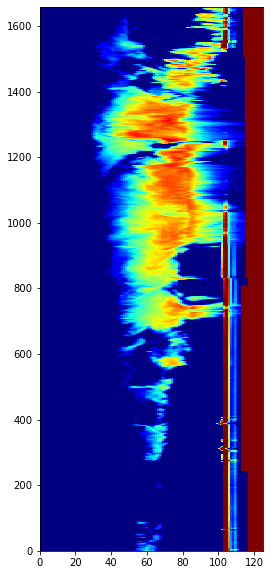

In [24]:
f = plt.figure(figsize=(4,10))
plt.pcolormesh(eq_ref,cmap=plt.cm.get_cmap('jet',100),vmin=-25, vmax=25)

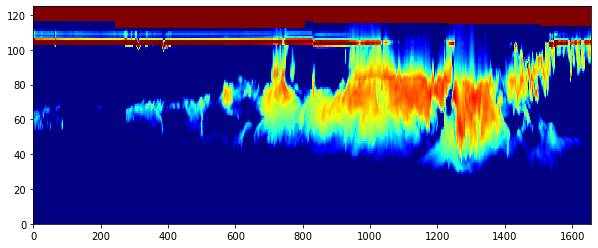

In [25]:
f = plt.figure(figsize=(10,4))
plt.pcolormesh(t_ref,cmap=plt.cm.get_cmap('jet',100),vmin=-25, vmax=25)

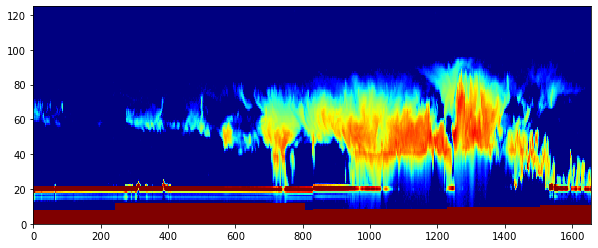

In [26]:
f = plt.figure(figsize=(10,4))
plt.pcolormesh(r_ref,cmap=plt.cm.get_cmap('jet',100),vmin=-25, vmax=25)

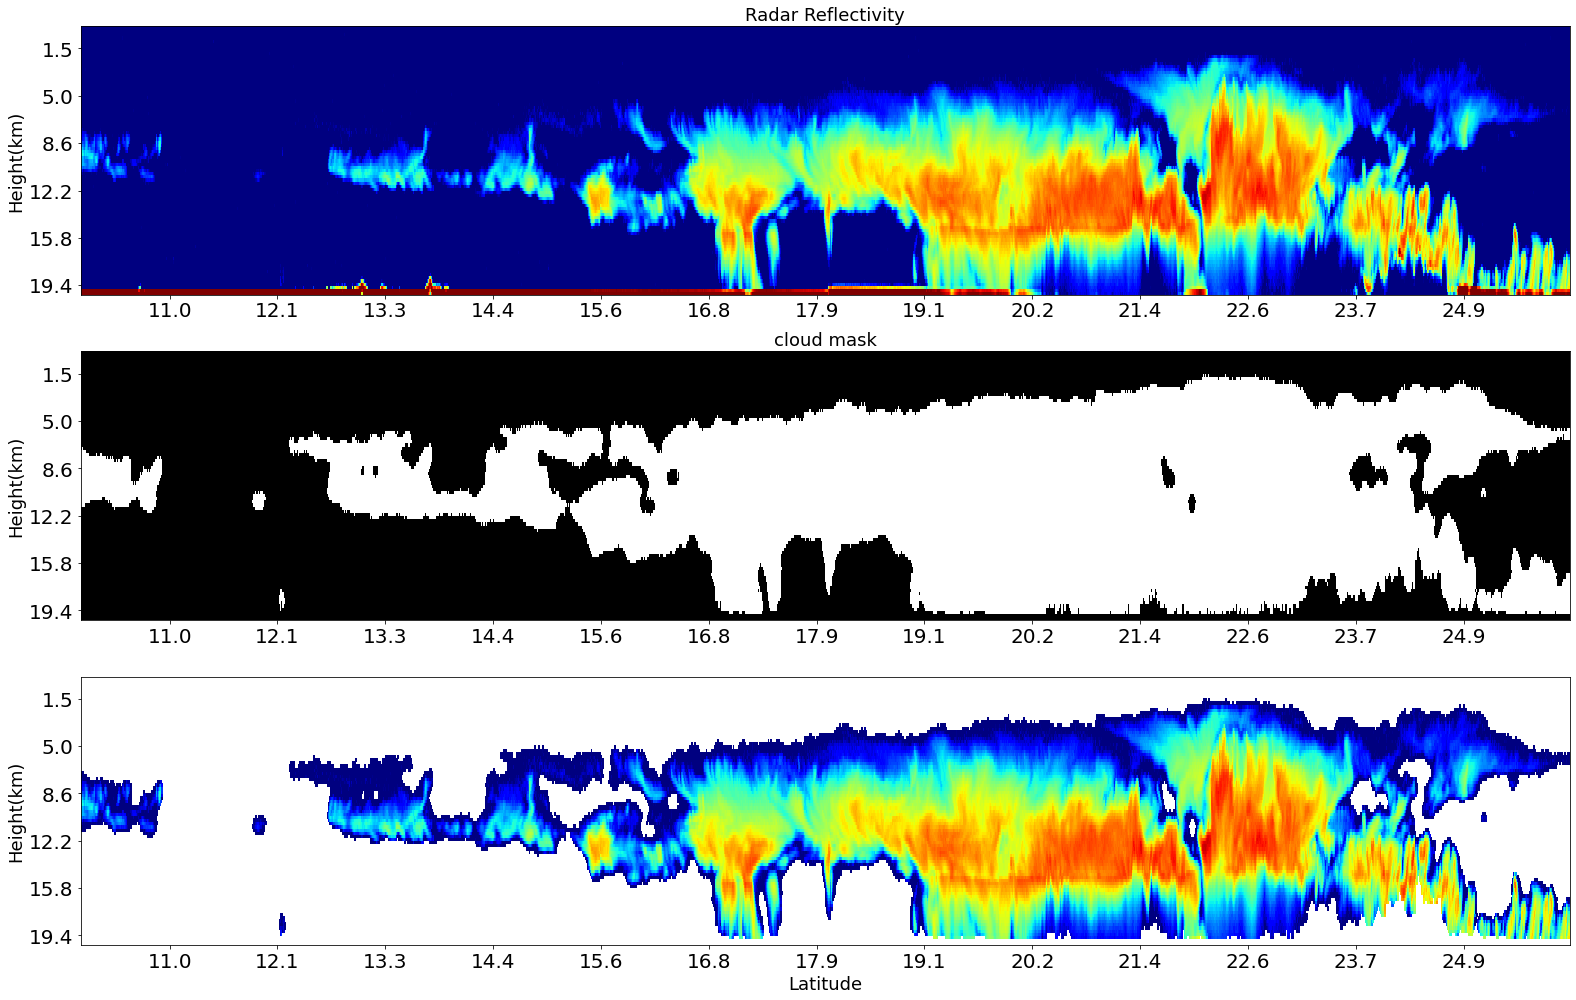

In [30]:
f = plt.figure(figsize=(22,14))
## first figure: reflectivity
axs = f.add_subplot(3,1,1)
plt.pcolormesh(r_ref[20:105,:],cmap=plt.cm.get_cmap('jet',100),vmin=-25, vmax=25)
plt.title('Radar Reflectivity',fontsize=18)
# axis setting
plt.yticks(np.arange(3,90,step=15), (ref_height[23:110:15,]),fontsize=20)
plt.xticks(np.arange(99,region_array_size[0],step=120), (region_lat[99:region_array_size[0]:120,]),fontsize=20)
plt.ylabel('Height(km)',color='k',fontsize=18)

## second figure: cloud mask
axs = f.add_subplot(3,1,2)
masked_cloud = np.where(r_cloud >= 19.5, r_cloud, 0) 
plt.pcolormesh(masked_cloud[20:105,:],cmap=plt.cm.get_cmap('gist_gray',2),vmin=19, vmax=20, alpha=1)
plt.title('cloud mask',fontsize=18)
# axis setting
plt.yticks(np.arange(3,90,step=15), (ref_height[23:110:15,]),fontsize=20)
plt.xticks(np.arange(99,region_array_size[0],step=120), (region_lat[99:region_array_size[0]:120,]),fontsize=20)
plt.ylabel('Height(km)',color='k',fontsize=18)

## third figure: reflectivity filtered by cloud mask
axs = f.add_subplot(3,1,3)
ref_masked = np.ma.masked_where(masked_cloud < 19.5 , r_ref)
plt.pcolormesh(ref_masked[20:105,:],cmap=plt.cm.get_cmap('jet',100),vmin=-25, vmax=25)
#plt.pcolormesh(masked_cloud[20:105,:],cmap=plt.cm.get_cmap('gist_gray',100),vmin=5,vmax=19,alpha=0.2)
# axis setting
plt.yticks(np.arange(3,90,step=15), (ref_height[23:110:15,]),fontsize=20)
plt.xticks(np.arange(99,region_array_size[0],step=120), (region_lat[99:region_array_size[0]:120,]),fontsize=20)
plt.ylabel('Height(km)',color='k',fontsize=18)
plt.xlabel('Latitude',color='k',fontsize=18)
plt.tight_layout()
#plt.savefig('r04_geoprof.png',dpi=300)